In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

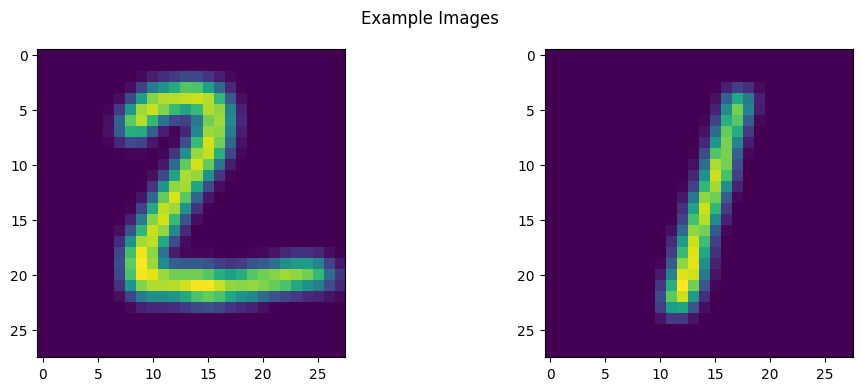

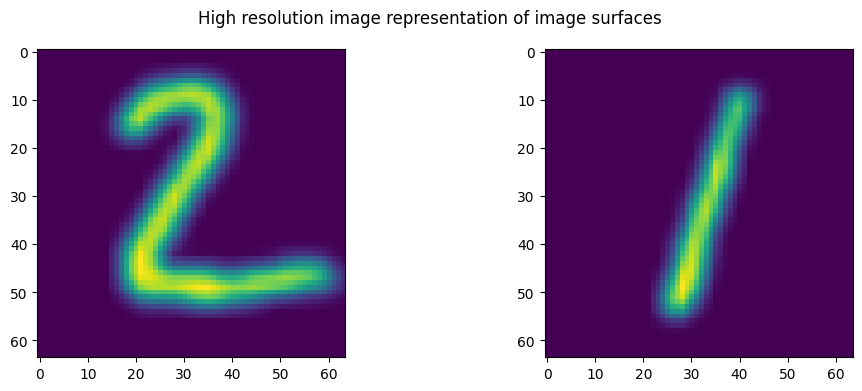

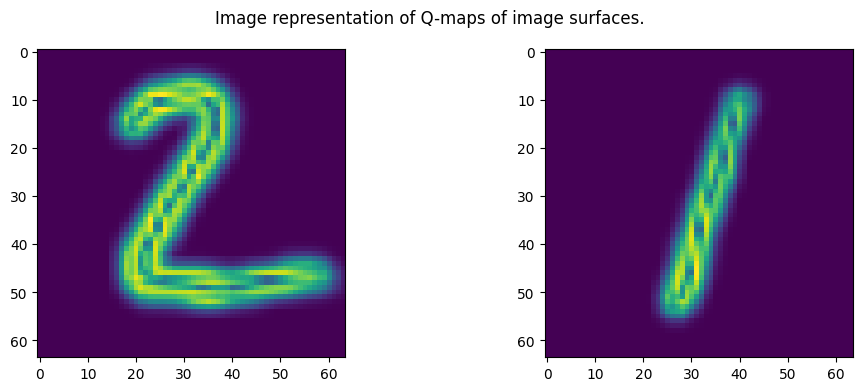

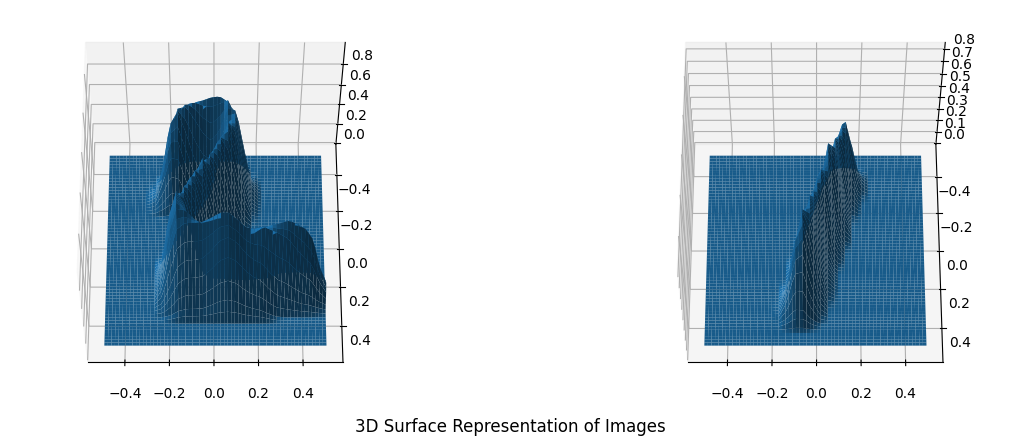

In [3]:
# Load Data
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [3, 3])
imgdata /= imgdata.max()

# Extract example images
img1 = imgdata[1]
img2 = imgdata[2]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.suptitle("Example Images")
plt.show()

# Create surface representation of images
f = SingleChannelImageSurface(img1, centering=True, mode='bicubic')
g = SingleChannelImageSurface(img2, centering=True, mode='bicubic')

# Find example data of surface representations of the images.
k = 64
XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

# Plotting
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.suptitle("High resolution image representation of image surfaces")
plt.show()

# Create sample data of Q-map representations of the images.
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

# Plot the q-map representation as images.
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.suptitle("Image representation of Q-maps of image surfaces.")
plt.show()


# 3D-plot of the surface representation of the images. 
fig = plt.figure(figsize=(12, 4))
fig.suptitle("3D Surface Representation of Images")
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()

ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.invert_xaxis()
plt.show(fig)

[Iter     1] loss: 0.554837
[Iter     6] loss: 0.438617
[Iter    11] loss: 0.347420
[Iter    16] loss: 0.306873
[Iter    21] loss: 0.307729
[Iter    26] loss: 0.273628
[Iter    31] loss: 0.279327
[Iter    36] loss: 0.250956
[Iter    41] loss: 0.236928
[Iter    46] loss: 0.230057
[Iter    51] loss: 0.226283
[Iter    56] loss: 0.216399
[Iter    61] loss: 0.228131
[Iter    66] loss: 0.221773
[Iter    71] loss: 0.208190
[Iter    76] loss: 0.223712
[Iter    81] loss: 0.214481
[Iter    86] loss: 0.226788
[Iter    91] loss: 0.192627
[Iter    96] loss: 0.211251
[Iter   101] loss: 0.202210
[Iter   106] loss: 0.203981
[Iter   111] loss: 0.200183
[Iter   116] loss: 0.211009

Finished training in 18.29025s


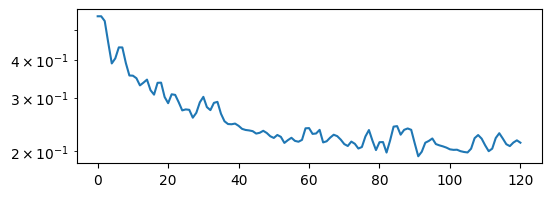

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Define reparametrization-network
RN = ReparametrizationNetwork(nn.ModuleList(
    [PalaisLayer(5, init_scale=0., projection_method="eigen") for _ in range(5)]
)).to(device)

loss_func = SingleComponentLoss(q, r, k=64, h=1e-4).to(device)
# loss_func = ShapeDistance(q, r, k=64, h=1e-4).to(device)

# Define optimizer and learning rate scheduler
optimizer = optim.LBFGS(RN.parameters(), lr=1., max_iter=100, line_search_fn="strong_wolfe")
optimizer = optim.SGD(RN.parameters(), lr=1e-2, momentum=0.9)

# Train and store convergence
errors = reparametrize(q, r, RN, loss_func, optimizer, 120, Logger(5), projection_kwargs={"epsilon": 1e-2})#, scheduler=scheduler)

RN.to("cpu"), loss_func.to("cpu");

plt.figure(figsize=(6, 2))
plt.semilogy(errors)
plt.show()

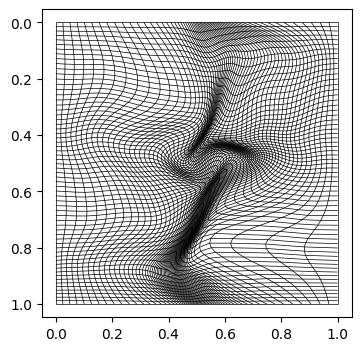

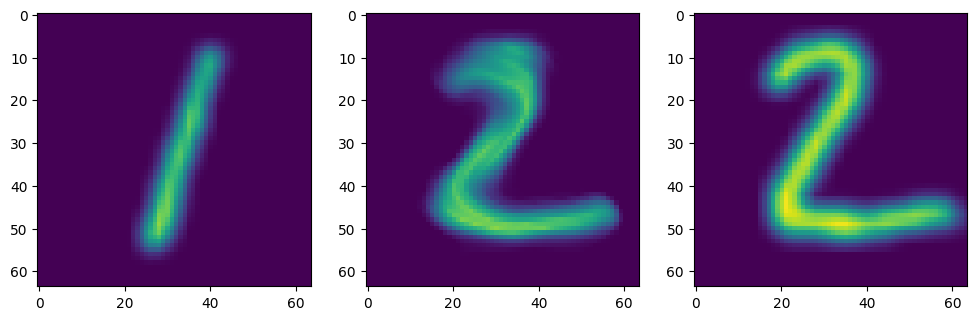

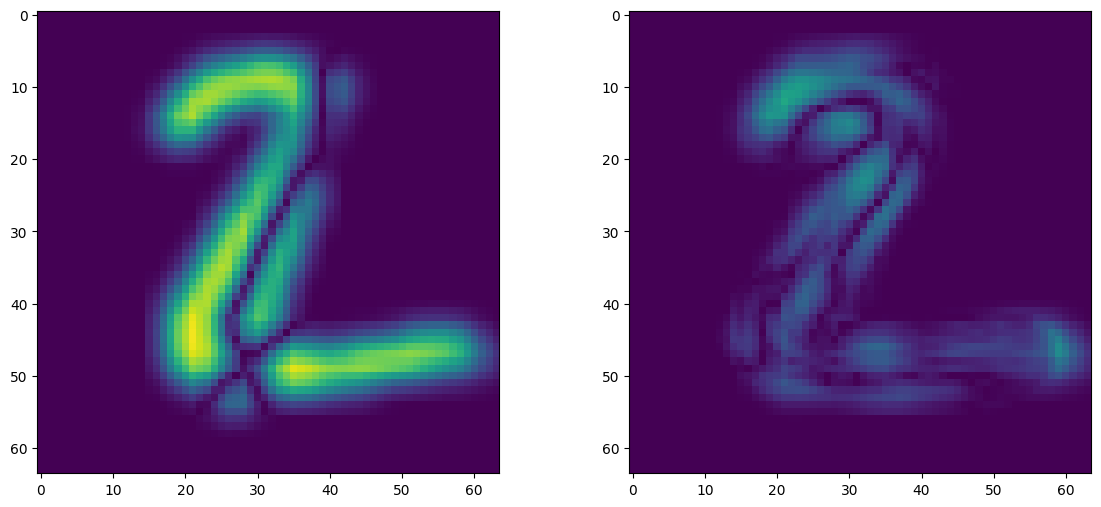

In [5]:
# =============== PLotting below +============
u = lambda x: RN(x)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_diffeomorphism(u, k=64, ax=ax, color="k", lw=0.5)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-diffeomorphism.pdf")


fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp.pdf")
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(np.abs(Zf[2] - Zg[2]), vmin=0., vmax=1.)
ax3.imshow(np.abs(Zf[2] - Zgg[..., 2]), vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-error.pdf")
plt.show()